# Exercise 7

## Group ID:
## Exercise day:

### Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
import torch.nn.functional as F
import numpy as np
from collections import Counter

## Description

This exercise sheet has the following subtasks:

1. Normalization <br>
    (a) Implement Layer Normalization (1.5 point) <br>
    (b) Implement Group Normalization (1.5 point) <br>
2. Imbalanced Classes <br>
    (a) Implement Focal loss (1.5 point) <br>
    (b) Train loop and comparison (0.5 point) <br>
    

### 1. Normalization

#### (a) Layer Normalization (1.5 point)

Layer Normalization (LN) is a technique that normalizes the inputs across the features of a layer for each data point, rather than across the batch as in Batch Normalization. It is defined as:


$\text{LN}(x) = \gamma \cdot \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta$,


where:
-   $x \in \mathbb{R}^{d_1\times d_2 \times \dots \times d_{R}}$ is a Tensor of order R
-	$\mu$ is the mean of the features for the input tensor $x$ according to the last D dimensions.
-	$\sigma^2$ is the variance of the features for the input tensor $x$ according to the last D dimensions.
-	$\gamma$ and $\beta$: Learnable parameters of shape $(d_{R-D+1}, d_{R-D+2}, \dots, d_{R})$ used for scaling and shifting.
-	$\epsilon$: A small constant added to the denominator for numerical stability.

The following figure illustrates this for a Tensor $x$ of shape (N, C, H, W), where N is the batch size, C is the number of channels and H,W the spatial dimensions. The Layer Norm in this example is calculated over the **last three** dimension (C,H,W):

![Layer Norm figure](https://pytorch.org/docs/stable/_images/layer_norm.jpg)<br>
For more details you can refer to the paper [Layer Normalization (Ba et al.)](https://arxiv.org/abs/1607.06450)

Task: Implement Layer Normalization as a `PyTorch Module`

In [14]:
class LayerNormCustom(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super(LayerNormCustom, self).__init__()
        ### your code here ###
        self.eps = eps
        self.normalized_shape = normalized_shape
        ######################

    def forward(self, x):
        ### your code here ###
        dims = [-(i+1) for i in range(len(self.normalized_shape))]
        xmean = x.mean(dim = dims, keepdims = True)
        xmean_2 = (x**2).mean(dim = dims, keepdims = True)
        xvar = xmean_2 - xmean**2
        #xvar = x.var(dim = dims, keepdims = True)

        x_hat = (x - xmean) / torch.sqrt(xvar + self.eps)
        return x_hat
        ######################

Test LayerNorm against the reference implementation

In [5]:
# Test against PyTorch's implementation
x = torch.randn(10, 20, 30)
ln = nn.LayerNorm(x.shape[-2:])
ln_custom = LayerNormCustom(x.shape[-2:])
assert torch.allclose(ln(x), ln_custom(x), atol=1e-6)
print("Test passed!")

Test passed!


In [15]:
# test to delete
x = torch.randn(2, 3, 4)
normalized_shape = x.shape[-2:]
dims = [-(i+1) for i in range(len(normalized_shape))]
print(x,x.mean(dim = dims, keepdims = True), torch.sum(x[0])/12, torch.sum(x[1])/12)

tensor([[[ 1.3200e+00, -2.8672e-01, -3.8429e-01, -1.1731e+00],
         [-2.0198e-01,  5.8797e-01,  1.2449e+00,  9.0641e-01],
         [-4.5002e-01,  1.4056e+00, -7.0341e-01, -1.0727e-03]],

        [[-8.1341e-01, -2.1760e-02, -8.3198e-02,  8.9873e-01],
         [-1.9946e+00,  5.0453e-01, -1.6472e-01, -1.5331e-01],
         [ 6.7120e-01, -1.0612e+00, -9.1990e-01, -1.2303e+00]]]) tensor([[[ 0.1887]],

        [[-0.3640]]]) tensor(0.1887) tensor(-0.3640)


#### (b) Group Normalization (1.5 point)

1. Input Tensor:  $\mathbf{x} \in \mathbb{R}^{N \times C \times \dots}$ , where $N$ is the batch size, $C$ is the number of features (e.g., channels), and the remaining dimensions $(H, W, \dots)$ are spatial or sequence dimensions.
2.	Groups: Divide the C channels/features into G groups (provided as an argument).
3.	Normalization: Normalize each group independently.
	-	For a group g, compute:
	-	The mean:  $\mu_g$
	-	The variance:  $\sigma_g^2$
	-	Apply normalization:

$$\hat{x}_g = \frac{x_g - \mu_g}{\sqrt{\sigma_g^2 + \epsilon}}$$

4.	Scale and Shift: Apply learnable parameters $\gamma$ and $\beta$:

$y = \gamma \cdot \hat{x} + \beta$

where $\gamma$ and $\beta$ are vectors of size $C$.

The Figure 2. in the paper [Group Normalization](https://arxiv.org/abs/1803.08494) shows the different types of normalization techniques

![Normalization](normalization.png)

In [15]:
class GroupNormCustom(nn.Module):
    def __init__(self, num_features, num_groups, eps=1e-5):
        """
        Args:
            num_features (int): Number of features (e.g., channels in an image).
            num_groups (int): Number of groups to divide the features into.
            eps (float): A small value to prevent division by zero.
        """
        super(GroupNormCustom, self).__init__()
        ### your code here ###
        self.num_features = num_features
        self.num_groups = num_groups
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(self.num_features))
        self.beta = nn.Parameter(torch.zeros(self.num_features))
        ######################

    def forward(self, x):
        """
        Apply Group Normalization.

        Args:
            x (torch.Tensor): Input tensor of shape (N, C, ...).

        Returns:
            torch.Tensor: Normalized tensor with the same shape as x.
        """
        ### your code here ###
        n, c, h, w = x.shape
        x = x.view(n, self.num_groups, -1)
        xmean = x.mean(dim = [-1], keepdim = True)
        xmean_2 = (x**2).mean(dim = [-1], keepdim = True)
        xvar = xmean_2 - xmean**2
        x_hat = (x - xmean) / torch.sqrt(xvar + self.eps)

        x_hat = x_hat.view(n, self.num_features, -1)
        x_hat = self.gamma.view(1, -1, 1)*x_hat + self.beta.view(1, -1, 1)
        return x_hat.view([n, c, h, w])
        ######################

Test GroupNorm against the reference implementation

In [23]:
num_features = 32
# Random input tensor
x = torch.randn(4, num_features, 16, 16)  # Shape (N, C, H, W)

# Custom GroupNorm
num_groups = 4 # must be a divisor of C
custom_gn = GroupNormCustom(num_features=num_features, num_groups=num_groups)

# PyTorch GroupNorm
torch_gn = nn.GroupNorm(num_groups=num_groups, num_channels=8)
#torch_gn = nn.GroupNorm(num_groups=num_groups, num_channels=num_features)
torch_gn.weight.data = custom_gn.gamma.data.clone()  # Match gamma
torch_gn.bias.data = custom_gn.beta.data.clone()  # Match beta

# Compare outputs
custom_out = custom_gn(x)
torch_out = torch_gn(x)

assert torch.allclose(custom_out, torch_out)
print("Test passed!")

Test passed!


In [24]:
# test to delete
num_features = 32
# Random input tensor
x = torch.randn(4, num_features, 16, 16)  # Shape (N, C, H, W)

# Custom GroupNorm
num_groups = 4 # must be a divisor of C
custom_gn = GroupNormCustom(num_features=num_features, num_groups=num_groups)

# PyTorch GroupNorm
torch_gn = nn.GroupNorm(num_groups=num_groups, num_channels=8)
#torch_gn = nn.GroupNorm(num_groups=num_groups, num_channels=num_features)
torch_gn.weight.data = custom_gn.gamma.data.clone()  # Match gamma
torch_gn.bias.data = custom_gn.beta.data.clone()  # Match beta

# Compare outputs
custom_out = custom_gn(x)
torch_out = torch_gn(x)
print(custom_out.shape)

torch.Size([4, 32, 16, 16])


#### Compare Plain DeeperCNN with LayerNorm and GroupNorm
The following part is just for demonstration purposes. If you implemented the Normalization correct, you should be able to run the following code without any errors.

We will use LayerNorm and GroupNorm to make DeeperCNN (the one from the lecture) model work again.

In [10]:
class DeeperCNN(nn.Module):
    def __init__(self, c_in=1, c_out=10, hidden_dim_1=4, hidden_dim_2=8, nr_convs_per_block=2, activation=nn.ReLU):
        super(DeeperCNN, self).__init__()

        self.ops = []
        self.conv_block_1 = [
            nn.Conv2d(in_channels=c_in, out_channels=hidden_dim_1, kernel_size=(3,3), padding=1),
            activation(),
        ]
        for i in range(nr_convs_per_block-1):
            self.conv_block_1.extend([
            nn.Conv2d(in_channels=hidden_dim_1, out_channels=hidden_dim_1, kernel_size=(3,3), padding=1),
            activation()
            ])
        self.conv_block_1.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)))
        self.conv_block_1 = nn.Sequential(*self.conv_block_1)

        self.conv_block_2 = [
            nn.Conv2d(in_channels=hidden_dim_1, out_channels=hidden_dim_2, kernel_size=(3,3), padding=1, stride=1),
            activation()
        ]
        for i in range(nr_convs_per_block-1):
            self.conv_block_2.extend([
            nn.Conv2d(in_channels=hidden_dim_2, out_channels=hidden_dim_2, kernel_size=(3,3), padding=1, stride=1),
            activation()
            ])
        self.conv_block_2.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)))
        self.conv_block_2 = nn.Sequential(*self.conv_block_2)

        self.MLP = nn.Sequential(
            nn.Flatten(start_dim=-3, end_dim=-1),
            nn.Linear(in_features=7*7*hidden_dim_2, out_features=c_out),
            # nn.Softmax() -> no softmax, cross entropy loss in pytorch already applies softmax
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.MLP(x)
        return x

In [11]:
class DeeperCNNLayerNorm(nn.Module):
    def __init__(self, c_in=1, c_out=10, hidden_dim_1=4, hidden_dim_2=8, nr_convs_per_block=2, activation=nn.ReLU):
        super(DeeperCNNLayerNorm, self).__init__()

        self.ops = []
        self.conv_block_1 = [
            nn.Conv2d(in_channels=c_in, out_channels=hidden_dim_1, kernel_size=(3,3), padding=1),
            LayerNormCustom((hidden_dim_1,28,28)),
            activation(),
        ]
        for i in range(nr_convs_per_block-1):
            self.conv_block_1.extend([
            nn.Conv2d(in_channels=hidden_dim_1, out_channels=hidden_dim_1, kernel_size=(3,3), padding=1),
            LayerNormCustom((hidden_dim_1,28,28)),
            activation()
            ])
        self.conv_block_1.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )
        self.conv_block_1 = nn.Sequential(*self.conv_block_1)

        self.conv_block_2 = [
            nn.Conv2d(in_channels=hidden_dim_1, out_channels=hidden_dim_2, kernel_size=(3,3), padding=1, stride=1),
            LayerNormCustom((hidden_dim_2,14,14)),
            activation()
        ]
        for i in range(nr_convs_per_block-1):
            self.conv_block_2.extend([
            nn.Conv2d(in_channels=hidden_dim_2, out_channels=hidden_dim_2, kernel_size=(3,3), padding=1, stride=1),
            LayerNormCustom((hidden_dim_2,14,14)),
            activation()
            ])
        self.conv_block_2.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )
        self.conv_block_2 = nn.Sequential(*self.conv_block_2)

        self.MLP = nn.Sequential(
            nn.Flatten(start_dim=-3, end_dim=-1),
            nn.Linear(in_features=7*7*hidden_dim_2, out_features=c_out),
            # nn.Softmax() -> no softmax, cross entropy loss in pytorch already applies softmax
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.MLP(x)
        return x

In [12]:
class DeeperCNNGroupNorm(nn.Module):
    def __init__(self, c_in=1, c_out=10, hidden_dim_1=4, hidden_dim_2=8, nr_convs_per_block=2, activation=nn.ReLU):
        super(DeeperCNNGroupNorm, self).__init__()

        self.ops = []
        self.conv_block_1 = [
            nn.Conv2d(in_channels=c_in, out_channels=hidden_dim_1, kernel_size=(3,3), padding=1),
            GroupNormCustom(hidden_dim_1, 2),
            activation(),
        ]
        for i in range(nr_convs_per_block-1):
            self.conv_block_1.extend([
            nn.Conv2d(in_channels=hidden_dim_1, out_channels=hidden_dim_1, kernel_size=(3,3), padding=1),
            GroupNormCustom(hidden_dim_1, 2),
            activation()
            ])
        self.conv_block_1.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )
        self.conv_block_1 = nn.Sequential(*self.conv_block_1)

        self.conv_block_2 = [
            nn.Conv2d(in_channels=hidden_dim_1, out_channels=hidden_dim_2, kernel_size=(3,3), padding=1, stride=1),
            GroupNormCustom(hidden_dim_2, 2),
            activation()
        ]
        for i in range(nr_convs_per_block-1):
            self.conv_block_2.extend([
            nn.Conv2d(in_channels=hidden_dim_2, out_channels=hidden_dim_2, kernel_size=(3,3), padding=1, stride=1),
            GroupNormCustom(hidden_dim_2, 2),
            activation()
            ])
        self.conv_block_2.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )
        self.conv_block_2 = nn.Sequential(*self.conv_block_2)

        self.MLP = nn.Sequential(
            nn.Flatten(start_dim=-3, end_dim=-1),
            nn.Linear(in_features=7*7*hidden_dim_2, out_features=c_out),
            # nn.Softmax() -> no softmax, cross entropy loss in pytorch already applies softmax
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.MLP(x)
        return x

### Data loading and splitting

In [2]:
fashion_mnist_train = datasets.FashionMNIST(root='data', train=True, download=True)
fashion_mnist_test = datasets.FashionMNIST(root='data', train=False, download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.2MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.75MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 22.7MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
X_train = fashion_mnist_train.data.reshape(-1, 1, 28, 28).float() / 255
y_train = fashion_mnist_train.targets

X_test = fashion_mnist_test.data.reshape(-1, 1, 28, 28).float() / 255
y_test = fashion_mnist_test.targets

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

In [5]:
def validate(model, X_val, y_val):
    # store model mode and set back to original mode after validation
    model_mode = model.training
    model.eval()
    correct_predictions = 0

    batch_size = 128
    with torch.no_grad(): # do not record gradients
        for i in range(0,X_val.shape[0],batch_size):
            x = torch.Tensor(X_val[i:i+batch_size]).to(device)
            x = x.reshape(-1, 1, 28, 28)
            y_true = y_val[i:i+batch_size]

            # Forward pass
            y_pred = model(x)

            # Get the predicted class (assuming y_pred is a Tensor with probabilities)
            predicted_class = torch.argmax(y_pred.data, dim=1)

            # Check if the prediction is correct
            correct_predictions += (predicted_class.cpu().numpy() == y_true).sum()


    # Calculate accuracy
    accuracy = correct_predictions / X_val.shape[0]
    model.train(model_mode)
    return accuracy

In [6]:
def train(model, X_train, y_train, X_test, y_test, num_epochs=3, lr=0.1, loss_fn=None):
    model.train()
    val_acc = validate(model, X_test, y_test)
    train_acc = validate(model, X_train, y_train)
    loss_fn = F.cross_entropy if loss_fn is None else loss_fn
    print(f"Training model {model.__class__.__name__} with {loss_fn} loss function for {num_epochs} epochs")
    print(f"Before training: validation accuracy: {val_acc}")

    # Parameters
    batch_size = 32

    # Training loop
    losses = []
    val_accs = []
    train_accs = []

    for epoch in range(num_epochs):
        # Shuffle the data at the beginning of each epoch
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]

        loss = 0.0

        for i in range(0, X_shuffled.shape[0], batch_size):
            X_batch = torch.Tensor(X_shuffled[i:i + batch_size]).to(device)
            X_batch = X_batch.reshape(-1,1,28,28)
            y_batch = torch.Tensor(y_shuffled[i:i + batch_size]).to(device)

            # Forward pass
            preds = model(X_batch)

            mb_loss = loss_fn(preds, y_batch)
            loss += mb_loss * X_batch.shape[0] / X_train.shape[0]

            #for layer in model.modules():
            #    layer.out.retain_grad() ### Just temproary

            ### ZERO GRAD ###
            for p in model.parameters():
                if p.grad is not None:
                    p.grad.zero_()
            # backward pass
            mb_loss.backward()

            # The weight update
            for p in model.parameters():
                p.data += -lr * p.grad

        losses.append(loss)
        val_acc = validate(model, X_test, y_test)
        val_accs.append(val_acc)

        train_acc = validate(model, X_train, y_train)
        train_accs.append(train_acc)
        print(f"Epoch {epoch}, Loss: {loss}, validation accuracy: {val_acc}, train accuracy: {train_acc}")

    return losses, val_accs, train_accs

In [16]:
nr_convs_per_block = 8

cnn_plain = DeeperCNN(nr_convs_per_block=nr_convs_per_block).to(device)
cnn_layernorm = DeeperCNNLayerNorm(nr_convs_per_block=nr_convs_per_block).to(device)
cnn_groupnorm = DeeperCNNGroupNorm(nr_convs_per_block=nr_convs_per_block).to(device)

As we compare the three models, we will see that the plain CNN model will not learn anything meaningful. This is due to vanishing gradients in deeper networks. But we will also see that the LayerNorm and GroupNorm can help tackle this problem.

In [13]:
num_epochs = 3
lr = 0.1

train(cnn_plain, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)
train(cnn_layernorm, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)
train(cnn_groupnorm, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)

Training model DeeperCNN with <function cross_entropy at 0x78cb6c0729e0> loss function for 3 epochs
Before training: validation accuracy: 0.10000000149011612
Epoch 0, Loss: 2.3033463954925537, validation accuracy: 0.10000000149011612, train accuracy: 0.10000000149011612
Epoch 1, Loss: 2.303520679473877, validation accuracy: 0.10000000149011612, train accuracy: 0.10000000149011612
Epoch 2, Loss: 2.303349733352661, validation accuracy: 0.10000000149011612, train accuracy: 0.10000000149011612
Training model DeeperCNNLayerNorm with <function cross_entropy at 0x78cb6c0729e0> loss function for 3 epochs
Before training: validation accuracy: 0.09619999676942825
Epoch 0, Loss: 0.6097087264060974, validation accuracy: 0.8222000002861023, train accuracy: 0.833633303642273
Epoch 1, Loss: 0.418120414018631, validation accuracy: 0.8539999723434448, train accuracy: 0.8642666935920715
Epoch 2, Loss: 0.3810403048992157, validation accuracy: 0.8646000027656555, train accuracy: 0.8771833181381226
Trainin

([tensor(0.5745, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.3757, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.3361, device='cuda:0', grad_fn=<AddBackward0>)],
 [tensor(0.8542), tensor(0.8721), tensor(0.8770)],
 [tensor(0.8619), tensor(0.8812), tensor(0.8845)])

### 2. Imbalanced Classes
The problem of imbalanced classes occurs in classification problems when one or more classes are significantly more common than others in the data. This imbalance can significantly affect the performance of machine learning models, as many algorithms tend to favour the dominant class and neglect the rarer classes.

Firstly, we will artificially construct an imbalanced dataset from the FashionMNIST dataset.

In [7]:
def create_imbalanced_dataset(X, y, num_samples_per_class):
    indices = []
    for cls, num_samples in num_samples_per_class.items():
        # Get indices of all samples for the current class
        cls_indices = torch.where(y == cls)[0]
        assert len(cls_indices) >= num_samples
        indices.extend(cls_indices[:num_samples])

    # Create the new dataset
    X_imbalanced = X[indices]
    y_imbalanced = y[indices]

    return X_imbalanced, y_imbalanced

In [8]:
samples_per_class = {k:(k+1)*600 for k in range(10)}
samples_per_class_test = {k:(k+1)*100 for k in range(10)}

X_train_imbalanced, y_train_imbalanced = create_imbalanced_dataset(X_train, y_train, samples_per_class)

X_test_imbalanced, y_test_imbalanced = create_imbalanced_dataset(X_test, y_test, samples_per_class_test)

imbalanced_labels = [target.item() for _,target in zip(X_train_imbalanced, y_train_imbalanced)]
for k,v in Counter(imbalanced_labels).items():
    print(f"Label {k}: {v} samples")

Label 0: 600 samples
Label 1: 1200 samples
Label 2: 1800 samples
Label 3: 2400 samples
Label 4: 3000 samples
Label 5: 3600 samples
Label 6: 4200 samples
Label 7: 4800 samples
Label 8: 5400 samples
Label 9: 6000 samples


#### (a) Implement Focal loss (1.5 point)

The $\alpha$-balanced focal loss is defined as:
$$
\mathcal{L}_{\text{focal}} = - \alpha_{t} (1 - p_t)^\gamma \log(p_t)
$$

Implement the $\alpha$-balanced focal loss with the following functionalities:
- Support multi-class classification.
- Accept parameters for $\alpha$ (class balancing) and $\gamma$ (focusing parameter).
- Return the loss value for a batch of inputs and targets.

Why does focal loss help?
- The $\gamma$ parameter down-weights the loss assigned to well-classified examples. This is useful when the dataset is imbalanced, as it helps the model to focus on the hard examples.
- The $\alpha$ parameter is used to balance the importance of the classes. This is useful when the dataset is imbalanced, as it helps the model to focus on the rare classes.

For more details, you can refer to the paper [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)

In [37]:
class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super(FocalLoss, self).__init__()
        ### your code here ###
        self.alpha = alpha
        self.gamma = gamma
        ######################

    def forward(self, scores, target):
        ### your code here ###
        log_softmax = F.log_softmax(scores, dim = 1)
        log_pt = torch.gather(log_softmax, dim = 1, index = target.view(-1, 1)).view(-1)
        pt = torch.exp(log_pt)
        alpha = self.alpha.to(target.device)[target]
        fl = -alpha*(1 - pt)**self.gamma*log_pt
        return torch.sum(fl)
        ######################


#### (b) Training loop and comparison (0.5 point)
Train the model with the focal loss and compare the results with the model trained with the cross-entropy loss. You can use the provided code to train the model.
After training, plot a confusion matrix for both models and compare the results in a few sentences.

Subtasks:
1. Train the model with both cross-entropy and focal loss (code is already given)
2. Implement confusion matrix code
3. Compare the results in a few sentences

In [38]:
# Train the model with Focal Loss
num_epochs = 10
nr_convs_per_block = 2
cnn_focal = DeeperCNN(nr_convs_per_block=nr_convs_per_block).to(device)
cnn_ce = DeeperCNN(nr_convs_per_block=nr_convs_per_block).to(device)
alpha = torch.Tensor([sum(samples_per_class.values()) / samples_per_class[k] for k in range(10)])
alpha = alpha / alpha.sum()
print(alpha)

tensor([0.3414, 0.1707, 0.1138, 0.0854, 0.0683, 0.0569, 0.0488, 0.0427, 0.0379,
        0.0341])


In [39]:
train(cnn_focal, X_train=X_train_imbalanced, y_train=y_train_imbalanced, X_test=X_test_imbalanced, y_test=y_test_imbalanced, num_epochs=num_epochs, lr=0.1, loss_fn=FocalLoss(alpha=alpha, gamma=2))

Training model DeeperCNN with FocalLoss() loss function for 10 epochs
Before training: validation accuracy: 0.10109090805053711
Epoch 0, Loss: 1.759844183921814, validation accuracy: 0.8241817951202393, train accuracy: 0.8330909013748169
Epoch 1, Loss: 0.47468578815460205, validation accuracy: 0.8579999804496765, train accuracy: 0.8579394221305847
Epoch 2, Loss: 0.41605114936828613, validation accuracy: 0.8589090704917908, train accuracy: 0.8672727346420288
Epoch 3, Loss: 0.3894190490245819, validation accuracy: 0.8759999871253967, train accuracy: 0.887333333492279
Epoch 4, Loss: 0.35651692748069763, validation accuracy: 0.8320000171661377, train accuracy: 0.8458485007286072
Epoch 5, Loss: 0.3491992652416229, validation accuracy: 0.8847272992134094, train accuracy: 0.8937878608703613
Epoch 6, Loss: 0.331964373588562, validation accuracy: 0.8341818451881409, train accuracy: 0.850151538848877
Epoch 7, Loss: 0.3201969563961029, validation accuracy: 0.8654545545578003, train accuracy: 0.87

([tensor(1.7598, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.4747, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.4161, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.3894, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.3565, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.3492, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.3320, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.3202, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.3173, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.3108, device='cuda:0', grad_fn=<AddBackward0>)],
 [tensor(0.8242),
  tensor(0.8580),
  tensor(0.8589),
  tensor(0.8760),
  tensor(0.8320),
  tensor(0.8847),
  tensor(0.8342),
  tensor(0.8655),
  tensor(0.8835),
  tensor(0.8693)],
 [tensor(0.8331),
  tensor(0.8579),
  tensor(0.8673),
  tensor(0.8873),
  tensor(0.8458),
  tensor(0.8938),
  tensor(0.8502),
  tensor(0.8761),
  tensor(0.8988),
  tensor(0.8804)])

In [25]:
train(cnn_ce, X_train=X_train_imbalanced, y_train=y_train_imbalanced, X_test=X_test_imbalanced, y_test=y_test_imbalanced, num_epochs=num_epochs, lr=0.1)

Training model DeeperCNN with <function cross_entropy at 0x79547398add0> loss function for 10 epochs
Before training: validation accuracy: 0.09072726964950562
Epoch 0, Loss: 0.6879103183746338, validation accuracy: 0.839090883731842, train accuracy: 0.8406969904899597
Epoch 1, Loss: 0.3618757128715515, validation accuracy: 0.8554545640945435, train accuracy: 0.864242434501648
Epoch 2, Loss: 0.3238814175128937, validation accuracy: 0.8896363377571106, train accuracy: 0.8921211957931519
Epoch 3, Loss: 0.3016812205314636, validation accuracy: 0.7770909070968628, train accuracy: 0.7800605893135071
Epoch 4, Loss: 0.2847248613834381, validation accuracy: 0.8912727236747742, train accuracy: 0.9029393792152405
Epoch 5, Loss: 0.27473556995391846, validation accuracy: 0.8794545531272888, train accuracy: 0.8938788175582886
Epoch 6, Loss: 0.2622237205505371, validation accuracy: 0.819636344909668, train accuracy: 0.8270605802536011
Epoch 7, Loss: 0.2564523220062256, validation accuracy: 0.87909090

([tensor(0.6879, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.3619, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.3239, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.3017, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.2847, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.2747, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.2622, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.2565, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.2502, device='cuda:0', grad_fn=<AddBackward0>),
  tensor(0.2438, device='cuda:0', grad_fn=<AddBackward0>)],
 [tensor(0.8391),
  tensor(0.8555),
  tensor(0.8896),
  tensor(0.7771),
  tensor(0.8913),
  tensor(0.8795),
  tensor(0.8196),
  tensor(0.8791),
  tensor(0.8900),
  tensor(0.8569)],
 [tensor(0.8407),
  tensor(0.8642),
  tensor(0.8921),
  tensor(0.7801),
  tensor(0.9029),
  tensor(0.8939),
  tensor(0.8271),
  tensor(0.8944),
  tensor(0.9015),
  tensor(0.8673)])

Now we compare the focal loss with the plain cross entropy loss on the imbalanced dataset

Here you have to implement the plot_confusion_matrix function.

In [58]:
# compare both models with confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    ### your code here ###
    mat_confusion = confusion_matrix(y_true, y_pred)
    plt.figure(figsize = (15, 10))
    fig, ax = plt.subplots()
    im = ax.imshow(mat_confusion, cmap = cmap)
    for i in range(len(classes)):
      for j in range(len(classes)):
        text = ax.text(j, i, mat_confusion[i, j],
                       ha="center", va="center", color="b")

    plt.title(title)
    #sn.heatmap(mat_confusion, annot=True)
    plt.show()
    ######################

<Figure size 1500x1000 with 0 Axes>

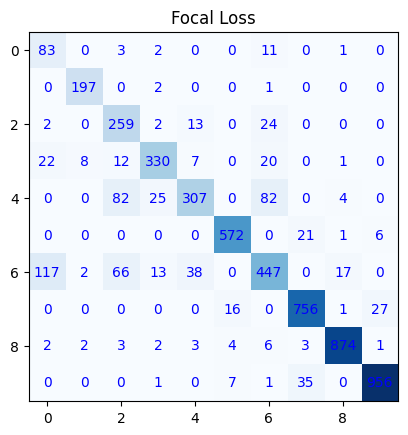

<Figure size 1500x1000 with 0 Axes>

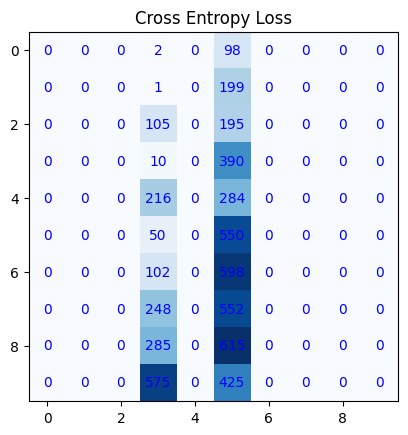

In [59]:
# confusion matrix for focal loss
cnn_focal.eval()
y_pred = []
for i in range(0, X_test_imbalanced.shape[0], 32):
    x = X_test_imbalanced[i:i+32].to(device)
    y = y_test_imbalanced[i:i+32]
    y_pred.extend(torch.argmax(cnn_focal(x), dim=1).cpu().numpy())
plot_confusion_matrix(y_test_imbalanced, y_pred, classes=fashion_mnist_train.classes, title="Focal Loss")

# confusion matrix for cross entropy loss
cnn_ce.eval()
y_pred = []
for i in range(0, X_test_imbalanced.shape[0], 32):
    x = X_test_imbalanced[i:i+32].to(device)
    y = y_test_imbalanced[i:i+32]
    y_pred.extend(torch.argmax(cnn_ce(x), dim=1).cpu().numpy())
plot_confusion_matrix(y_test_imbalanced, y_pred, classes=fashion_mnist_train.classes, title="Cross Entropy Loss")

In [55]:
cnn_focal.eval()
y_pred = []
for i in range(0, X_test_imbalanced.shape[0], 32):
    x = X_test_imbalanced[i:i+32].to(device)
    y = y_test_imbalanced[i:i+32]
    y_pred.extend(torch.argmax(cnn_focal(x), dim=1).cpu().numpy())
a = set(y_pred)
a

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Your interpretation of the results: